# 311 (Cityworks_Service_Requests)
Download from [opendc](http://opendata.dc.gov/datasets/cityworks-service-requests) on 05/20/2017

738322 lines of data, 279714 without PARKING METER REQUES

plot distribution:
- by DESCRIPTION: 
    - too many PARKING METER REQUES: 62.11%. 
    - removing PARKING METER REQUES: 71 types, top 3 takes up 43.87% (['STREETLIGHT REPAIR', 'POTHOLES', 'TREE INSPECTION']), top 12 takes up 84.45%.
- by INITIATEDDATE: filter PARKING METER REQUES and timestamp<'2009'. Seems normal
- by segs:
    - 4392 points match          0 segment,    0.5% 
    - 733930 points match at least 1 segment   1.5% has >= 5 segments

# Crashes
Download from [opendc](http://opendata.dc.gov/datasets/crashes-in-the-district-of-columbia) on 05/19/2017

plot distribution:
- col = FIRSTHARMFULEVENTSPECIFICS: 44 types, top 3 is ['Motor Vehicle In Transport', 'Parked Motor Vehicle', 'Hit and Run'], taking up 81% of all crashes
- col = CRASHEVENTTYPES: 16 types, top 3 is ['COLLISION_WITH_NON_FIXED, PENDING_INVESTIGATION', 'COLLISION_WITH_NON_FIXED', 'PENDING_INVESTIGATION'], 87%
- col = break down CRASHEVENTTYPES: 5 types, top 2 is ['COLLISION_WITH_NON_FIXED', 'PENDING_INVESTIGATION'], 92.52%
- by time (col=SOURCEADDTIME): from 2008-05-20 to 2016-05-27, seems normal
- by segs
    - 49133 points match          0 segment, 39.53%
    - 75145 points match at least 1 segment, 1.6%

# Vision Zero
Download from [opendc](http://opendata.dc.gov/datasets/vision-zero-safety) on 05/19/2017

plot distribution:
- by request types (17 types)
- by user types(3 types)
- by (user, request) (55 types)
- by time. From 07/02/2015 to 05/12/2017. 81%(4334) is before 10/01/2015
- by segs
    - 1    points match          0 segment
    - 5328 points match at least 1 segment 16.7%

----

----

In [1]:
import src.geom_helper; reload(src.geom_helper)

<module 'src.geom_helper' from 'src\geom_helper.pyc'>

In [2]:
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import Point
from src.geom_helper import pts2segs
from src.constants import epsg_dc
%matplotlib inline

In [3]:
seg_dc = gp.read_file('data/raw_data/segments_dc_opendc.geojson')

In [4]:
def distr_by_segs(pts_has_ln, pts_no_ln):
    how_many_segs_per_pt = pts_has_ln.groupby('index_pt').agg('count').index_ln.value_counts().to_dict()
    assert 0 not in how_many_segs_per_pt
    print '{:<4} points match          0 segment'.format(len(pts_no_ln))
    print '{:<4} points match at least 1 segment'.format(pts_has_ln['index_pt'].nunique())
    print '='*10
    for i, cnt in how_many_segs_per_pt.items():
        print '{:<4} points match {} segments'.format(cnt, i)
    
    print '=' * 10
    print 'Histogram of # pts per segment(one point could has more than one segment)'
    pts_has_ln.groupby('index_ln').agg('count').hist()

In [5]:

def match_pts2segs(gpdf, segs, epsg, chunk=10**5):

    if len(gpdf) > chunk:
        list_pts_has_ln, list_pts_no_ln = [], []
        size = len(gpdf)
        start = 0
        end = min(start+chunk, size)
        while(start< size):
            print 'matching chunk:', start, end
            pts_has_ln, pts_no_ln=pts2segs(gpdf[start:end], segs, epsg)
            list_pts_has_ln.append(pts_has_ln)
            list_pts_no_ln.append(pts_no_ln)

            start = end
            end = min(start+chunk, size)
        pts_has_ln = pd.concat(list_pts_has_ln, ignore_index=True)
        pts_no_ln = pd.concat(list_pts_no_ln, ignore_index=True)
    else:
        pts_has_ln, pts_no_ln=pts2segs(gpdf, segs, epsg)
        
    return pts_has_ln, pts_no_ln

# 311 (Cityworks_Service_Requests) Details

In [6]:
csr311 = pd.read_csv('data/raw_data/Cityworks_Service_Requests.csv')

D:\Program Files\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (4,15,23,26,32,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# too many PARKING METER REQUES in DESCRIPTION
(csr311.shape[0], 
 (csr311.DESCRIPTION=='PARKING METER REQUES').mean()*100, '%', 
 csr311[csr311.DESCRIPTION!='PARKING METER REQUES'].shape[0])

(738322, 62.114903795362999, '%', 279714)

# of DESCRIPTION: 71
236228 84.453405979 % ['STREETLIGHT REPAIR', 'POTHOLES', 'TREE INSPECTION', 'SIDEWALK REPAIR', 'TREE PRUNING', 'TREE PLANTING', 'TREE REMOVAL', 'ALLEYLIGHT REPAIR', 'SIGN REPLACE', 'TRAFFIC SIGNAL MAIN', 'STREET REPAIR', 'ALLEY REPAIR']


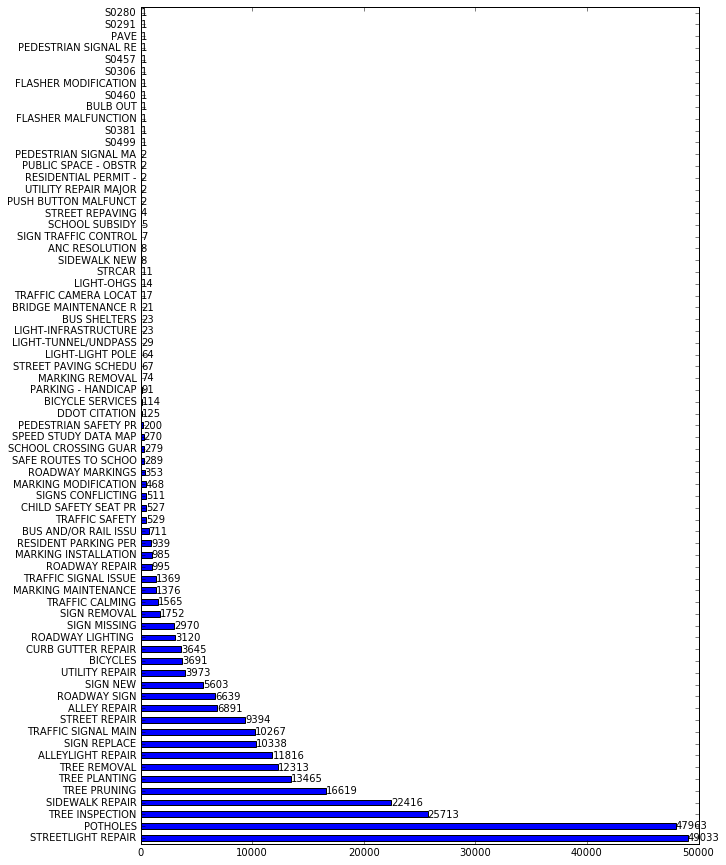

In [8]:
# distribution by DESCRIPTION without PARKING METER REQUES
d = csr311[csr311.DESCRIPTION!='PARKING METER REQUES'].DESCRIPTION.value_counts()
print '# of DESCRIPTION:', d.shape[0]
top = 12
print d[:top].sum(), d[:top].sum()*100.0/d.sum(), '%', d[:top].index.tolist()
ax = d.plot(kind='barh',figsize=(10,15))
for p in ax.patches:
    ax.annotate("%d" % p.get_width(), (p.get_x() + p.get_width() + 10, p.get_y()))

In [9]:
t = csr311[(csr311.INITIATEDDATE>'2009')&(csr311.DESCRIPTION!='PARKING METER REQUES')].INITIATEDDATE

2009-08-11T17:49:00.000Z 2017-05-14T03:28:11.000Z


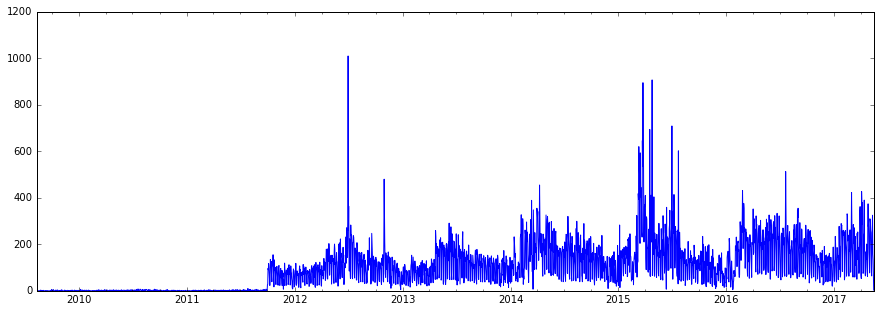

In [10]:
# distribution by INITIATEDDATE
min_time = t.min()
max_time = t.max()
print min_time, max_time
periods = (pd.Timestamp(max_time)- pd.Timestamp(min_time)).days+2
date_index = pd.date_range(min_time[:10], periods=periods, freq='D')

t = t.apply(lambda x: x[:10] if pd.notnull(x) else'').apply(pd.Timestamp)
d = t.value_counts()
d.reindex(date_index).fillna(0).plot(figsize=(15,5))

matching chunk: 0 100000


D:\Program Files\Anaconda2\lib\site-packages\numpy\lib\function_base.py:2287: RuntimeWarning: invalid value encountered in find_intersects (vectorized)
  outputs = ufunc(*inputs)


matching chunk: 100000 200000
matching chunk: 200000 300000
matching chunk: 300000 400000
matching chunk: 400000 500000
matching chunk: 500000 600000
matching chunk: 600000 700000
matching chunk: 700000 738322
4392 points match          0 segment
733930 points match at least 1 segment
571728 points match 1 segments
9271 points match 2 segments
50728 points match 3 segments
91107 points match 4 segments
8356 points match 5 segments
2130 points match 6 segments
610  points match 9 segments
Histogram of # pts per segment(one point could has more than one segment)


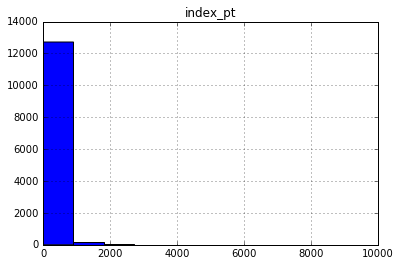

In [11]:
# distribution by segments matched
pts = csr311.apply(lambda x: Point(x.LONGITUDE, x.LATITUDE), axis=1)
gpdf = gp.GeoDataFrame(pts, columns=['geometry'])
pts_has_ln, pts_no_ln = match_pts2segs(gpdf, seg_dc, epsg_dc)
distr_by_segs(pts_has_ln, pts_no_ln)

In [12]:
(8356+2130+610)*1.0/len(csr311), 4392.0/len(csr311)

(0.015028673126359502, 0.005948624042084619)

# Crashes details

In [13]:
crashes = pd.read_csv('data/raw_data/Crashes_in_the_District_of_Columbia.csv')

D:\Program Files\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (4,5,6,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


123601 80.920363484 % ['Motor Vehicle In Transport', 'Parked Motor Vehicle', 'Hit and Run']
# of FIRSTHARMFULEVENTSPECIFICS: 44


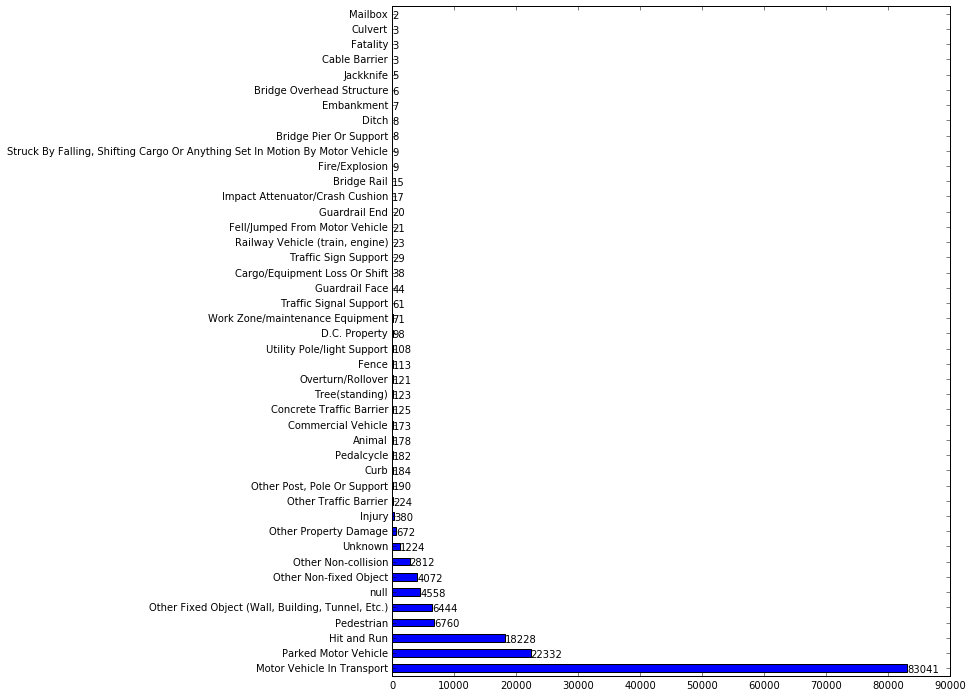

In [14]:
# distribution by FIRSTHARMFULEVENTSPECIFICS
d = crashes.FIRSTHARMFULEVENTSPECIFICS.value_counts()
top = 3
print d[:top].sum(), d[:top].sum()*100.0/d.sum(), '%', d[:top].index.tolist()
print '# of FIRSTHARMFULEVENTSPECIFICS:', d.shape[0]
ax = d.plot(kind='barh',figsize=(10,12))
for p in ax.patches:
    ax.annotate("%d" % p.get_width(), (p.get_x() + p.get_width() + 10, p.get_y()))

134123 87.8090137747 % ['COLLISION_WITH_NON_FIXED, PENDING_INVESTIGATION', 'COLLISION_WITH_NON_FIXED', 'PENDING_INVESTIGATION']
# of CRASHEVENTTYPES: 16


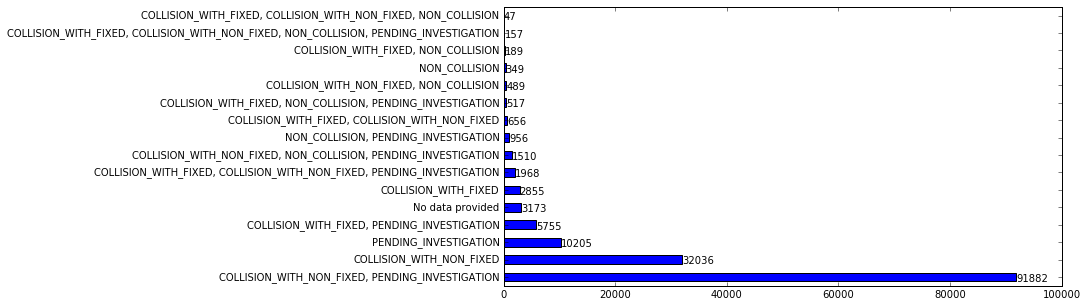

In [15]:
# distribution by CRASHEVENTTYPES
d = crashes.CRASHEVENTTYPES.value_counts()
top = 3
print d[:top].sum(), d[:top].sum()*100.0/d.sum(), '%',  d[:top].index.tolist()
print '# of CRASHEVENTTYPES:', d.shape[0]
ax = d.plot(kind='barh',figsize=(10,5))
for p in ax.patches:
    ax.annotate("%d" % p.get_width(), (p.get_x() + p.get_width() + 10, p.get_y()))

241695 92.523332287 % ['COLLISION_WITH_NON_FIXED', 'PENDING_INVESTIGATION']
# of CRASHEVENTTYPES: 5


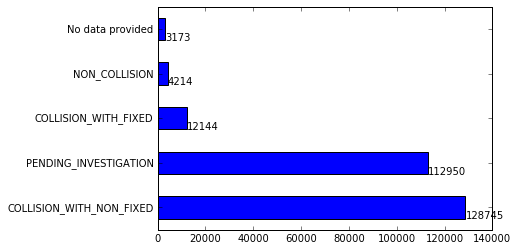

In [16]:
# break down CRASHEVENTTYPES
l = np.concatenate(crashes.CRASHEVENTTYPES.apply(lambda x: x.split(', ')).values)
d = pd.Series(l).value_counts()
top = 2
print d[:top].sum(), d[:top].sum()*100.0/d.sum(), '%',  d[:top].index.tolist()
print '# of CRASHEVENTTYPES:', d.shape[0]
ax = d.plot(kind='barh')
for p in ax.patches:
    ax.annotate("%d" % p.get_width(), (p.get_x() + p.get_width() + 10, p.get_y()))

2008-05-20T10:12:00.000Z 2016-05-27T12:03:00.000Z


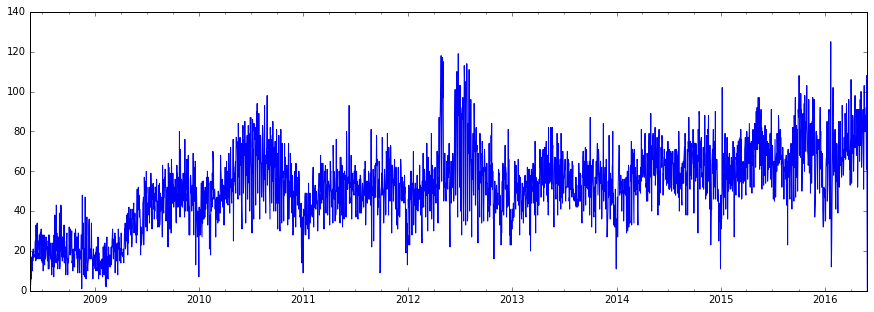

In [17]:
# distribution by SOURCEADDTIME
min_time = crashes.SOURCEADDTIME.min()
max_time = crashes.SOURCEADDTIME.max()
print min_time, max_time
periods = (pd.Timestamp(max_time)- pd.Timestamp(min_time)).days+2
date_index = pd.date_range(min_time[:10], periods=periods, freq='D')

t = crashes.SOURCEADDTIME.apply(lambda x: x[:10] if pd.notnull(x) else'').apply(pd.Timestamp)
d = t.value_counts()
d.reindex(date_index).fillna(0).plot(figsize=(15,5))

In [18]:
# Reportdate is kind of strange
t = crashes.REPORTDATE.apply(lambda x: x[:10] if pd.notnull(x) else'')
print t[(t<'2018-01-01') & (t>'2000-01-01')].max()
print t[t>'2018-01-01']
print t[(t<'2000-01-01')&(t!='')]


def cmp_add_report(row):
    add = row.SOURCEADDTIME
    rep = row.REPORTDATE
    if not pd.notnull(rep):
        return 'no report'
    if add[:10] == rep[:10]:
        return 'same day'
    if add[:7] == rep[:7]:
        return 'same month'
    if add[:4] == rep[:4]:
        return 'same year'
    if add[:10] > rep[:10]:
        return 'not same year, add later than rep'
    elif add[:10] < rep[:10]:
        return 'not same year, add earlier than rep'
    return 'unk'

l = crashes.apply(cmp_add_report, axis=1)
l.value_counts().sort_index()

2017-09-17
11669     2028-11-28
33350     2320-02-23
76145     2912-12-13
102937    2025-05-24
Name: REPORTDATE, dtype: object
6557      1975-05-26
7210      1908-06-21
114802    1908-07-19
Name: REPORTDATE, dtype: object


no report                                1520
not same year, add earlier than rep        89
not same year, add later than rep        5360
same day                               125623
same month                              17455
same year                                2697
dtype: int64

In [19]:
# null percentage of coordinate
no_x = crashes.X.isnull()
no_y = crashes.Y.isnull()
no_xy = no_x|no_y
no_segid = crashes.STREETSEGID.isnull()

print 'no coordinate: {}, no segid: {}'.format(no_xy.sum(), no_segid.sum())
print 'no coordinate or no segid: {}'.format((no_xy|no_segid).sum())
print 'no coordinate but has segid: {}'.format((no_xy&~no_segid).sum())
print 'has coordinate but no segid: {}'.format((~no_xy&no_segid).sum())

no coordinate: 28466, no segid: 30370
no coordinate or no segid: 30390
no coordinate but has segid: 20
has coordinate but no segid: 1924


matching chunk: 0 100000
matching chunk: 100000 124278
49133 points match          0 segment
75145 points match at least 1 segment
43257 points match 1 segments
626  points match 2 segments
7031 points match 3 segments
22244 points match 4 segments
1626 points match 5 segments
353  points match 6 segments
8    points match 9 segments
Histogram of # pts per segment(one point could has more than one segment)


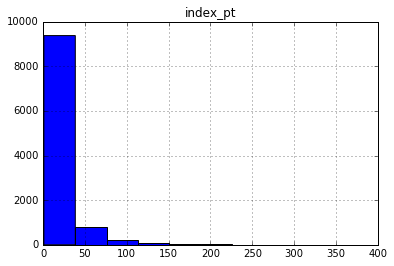

In [20]:
# distribution by segments matched
pts = crashes[~no_xy].apply(lambda x: Point(x.X, x.Y), axis=1)
gpdf = gp.GeoDataFrame(pts, columns=['geometry'])
pts_has_ln, pts_no_ln = match_pts2segs(gpdf, seg_dc, epsg_dc)
distr_by_segs(pts_has_ln, pts_no_ln)

In [21]:
49133.0/124278, (1626.0+353+8)/124278

(0.39534752731778755, 0.01598834870210335)

# Vision Zero details

In [22]:
vision0 = pd.read_csv('data/raw_data/Vision_Zero_Safety_dc.csv')

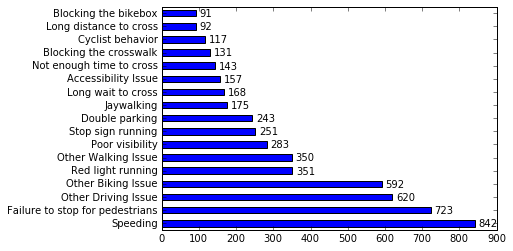

In [23]:
# distribution by request type
ax = vision0.REQUESTTYPE.value_counts().plot(kind='barh')
for p in ax.patches:
    ax.annotate("%d" % p.get_width(), (p.get_x() + p.get_width() + 10, p.get_y()))

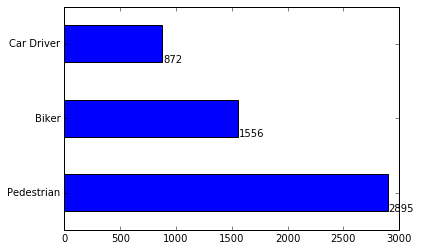

In [24]:
# distribution by user type
ax = vision0.USERTYPE.value_counts().plot(kind='barh')
for p in ax.patches:
    ax.annotate("%d" % p.get_width(), (p.get_x() + p.get_width() + 10, p.get_y()))

(55L,)


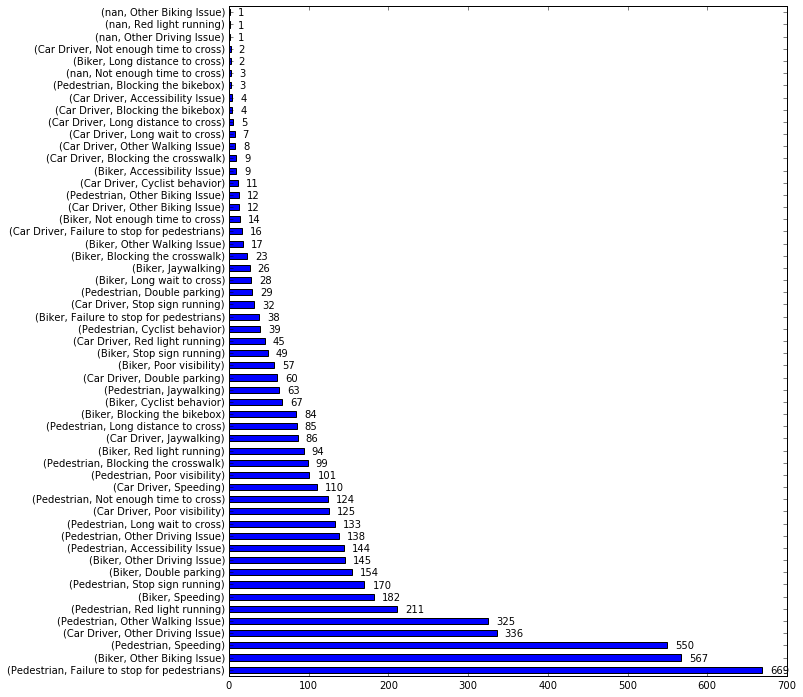

In [25]:
# distribution by user type and request type
d = vision0.apply(lambda x: (x.USERTYPE, x.REQUESTTYPE), axis=1).value_counts()
print d.shape
ax = d.plot(kind='barh', figsize=(10,12))
for p in ax.patches:
    ax.annotate("%d" % p.get_width(), (p.get_x() + p.get_width() + 10, p.get_y()))

{'sum': 4334.0, 'mean': 0.81328579470820039}


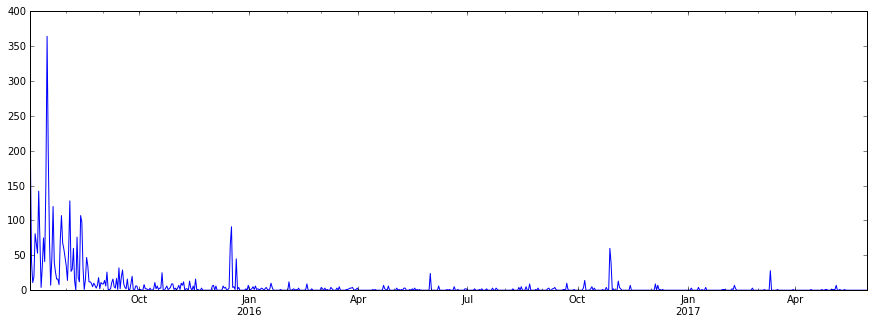

In [26]:
# distribution by time
t = vision0.REQUESTDATE.apply(lambda x: x[:10] if pd.notnull(x) else'').apply(pd.Timestamp)
print (t<pd.Timestamp('2015-10-01')).apply(['sum','mean']).to_dict()
d = t.value_counts()
date_index = pd.date_range('2015-07-02', periods=700, freq='D')
d.reindex(date_index).fillna(0).plot(figsize=(15,5))

In [27]:
no_x = vision0.X.isnull()
no_y = vision0.Y.isnull()
no_xy = no_x|no_y
no_segid = vision0.STREETSEGID.isnull()

print 'no coordinate: {}, no segid: {}'.format(no_xy.sum(), no_segid.sum())
print 'no coordinate or no segid: {}'.format((no_xy|no_segid).sum())
print 'no coordinate but has segid: {}'.format((no_xy&~no_segid).sum())
print 'has coordinate but no segid: {}'.format((~no_xy&no_segid).sum())

no coordinate: 0, no segid: 9
no coordinate or no segid: 9
no coordinate but has segid: 0
has coordinate but no segid: 9


1    points match          0 segment
5328 points match at least 1 segment
3417 points match 1 segments
91   points match 2 segments
653  points match 3 segments
1078 points match 4 segments
55   points match 5 segments
31   points match 6 segments
3    points match 9 segments
Histogram of # pts per segment(one point could has more than one segment)


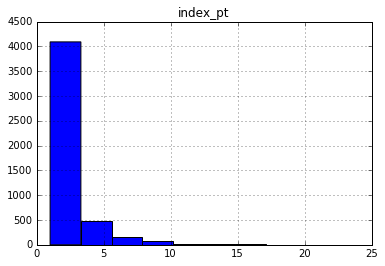

In [28]:
# distribution by segments matched
pts = vision0.apply(lambda x: Point(x.X, x.Y), axis=1)
gpdf = gp.GeoDataFrame(pts, columns=['geometry'])
pts_has_ln, pts_no_ln = match_pts2segs(gpdf, seg_dc, epsg_dc)
distr_by_segs(pts_has_ln, pts_no_ln)

In [29]:
(55.0+31+3)/5329

0.016701069619065492